In [2]:
import os
import sys
os.chdir("../")
sys.path.append("./")
import pandas as pd
import pickle
import tensorflow as tf

from LstmVAE import LSTM_Var_Autoencoder
from LstmVAE import preprocess
from IPython import embed
from common import data_preprocess
from common.dataloader import load_dataset
from common.sliding import WindowIterator

/Users/liujinyang/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/liujinyang/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/liujinyang/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/liujinyang/anacond

In [159]:
dataset = "SMD"
subdataset = "machine-1-1"

data_dict = load_dataset(
    dataset,
    subdataset,
    0,
)


# data_dict["train"] = preprocess(data_dict["train"])  # return normalized df, check NaN values replacing it with 0
# data_dict["test"] = preprocess(data_dict["test"])  # return normalized df, check NaN values replacing it with 0

train = data_dict["train"][0:10000]
test = data_dict["train"][0:10000]


window_dict = data_preprocess.generate_windows(
    data_dict,
    window_size=32,
    stride=1,
)

train = window_dict["train_windows"]  # return normalized df, check NaN values replacing it with 0
test = window_dict["test_windows"]  # return normalized df, check NaN values replacing it with 0

In [160]:
df_train = train.reshape(-1, *train.shape[-2:])
df_test = test.reshape(-1, *test.shape[-2:])
df_train.shape, df_test.shape

((28447, 32, 1), (28447, 32, 1))

In [161]:
vae = LSTM_Var_Autoencoder(
    intermediate_dim=15, z_dim=3, n_dim=df_train.shape[-1], stateful=True
)  # default stateful = False

vae.fit(
    df_train, learning_rate=0.001, batch_size = 100, num_epochs = 20, opt = tf.train.AdamOptimizer, REG_LAMBDA = 0.01,
            grad_clip_norm=10, optimizer_params=None, verbose = True
)



Training...


Epoch   1    Loss 0.01727
Epoch   11   Loss 0.00332


KeyboardInterrupt: 

In [162]:
x_reconstructed, recons_error = vae.reconstruct(
    df_train, get_error=True
)  # returns squared error

# x_reduced = vae.reduce(df_test)  # latent space representation

In [163]:
df_train.shape, x_reconstructed.shape

((28447, 32, 1), (28447, 32, 1))

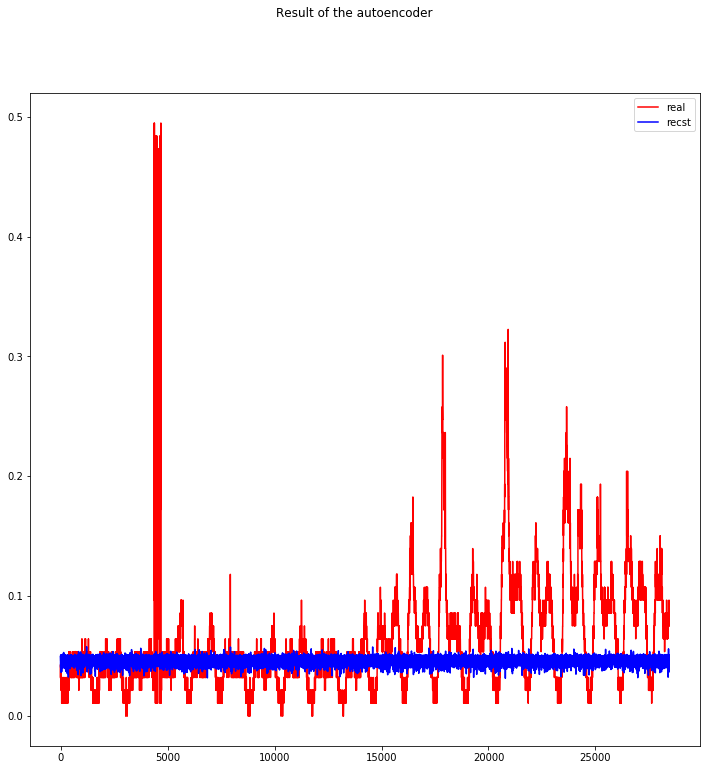

In [164]:
import matplotlib.pyplot as plt

# original = df_train[0, 10:, 0]
# recst = x_reconstructed[0, 10:, 0]

original = df_train[:, -1, 0]
recst = x_reconstructed[:, -1, 0]

fig, ax = plt.subplots(nrows=1, sharey=True, figsize=(12,12))

ax.plot(original.reshape(-1), 'r', label='real')
ax.plot(recst.reshape(-1), 'b', label='recst')

plt.legend()
plt.suptitle("Result of the autoencoder")
plt.show()

In [165]:
original.reshape(-1)

array([0.032258, 0.043011, 0.043011, ..., 0.086022, 0.086022, 0.086022],
      dtype=float32)

In [166]:
x_reconstructed.reshape(-1)

array([0.02428864, 0.0409509 , 0.04947012, ..., 0.04958106, 0.04958053,
       0.04958021], dtype=float32)